# Geodata Hacks

## Massage Swisstopo Boundary Data

`data/towns.geojson` contains the polygons for Swiss admin entities such as `Gemeinde`, `Bezirk`, `Kanton` etc, but we need to massage the dataset a bit to be compatible with the TG datasets.

### Steps 1: Import the data and have a look

In [4]:
import geopandas
municipalities = geopandas.read_file("../data/towns.geojson")
municipalities


,gml_id,nationalCode,localId,namespace,versionId,LocalisedCharacterString,Country,language,nativeness,sourceOfName,pronunciation,text,script,residenceOfAuthority,beginLifespanVersion,boundary,geometry
0,AdministrativeUnit_Gemeinde_3762,CH,AdministrativeUnit_Gemeinde_3762,https://www.swisstopo.ch/inspire/au/4.0/swissb...,1_4,Gemeinde,CH,NaN,NaN,NaN,NaN,Scuol,NaN,NaN,2008-11-24 00:00:00+00:00,NaN,"MULTIPOLYGON (((1139077.532 5921141.517, 11400..."
1,AdministrativeUnit_Gemeinde_3575,CH,AdministrativeUnit_Gemeinde_3575,https://www.swisstopo.ch/inspire/au/4.0/swissb...,1_4,Gemeinde,CH,NaN,NaN,NaN,NaN,Laax,NaN,NaN,2008-11-24 00:00:00+00:00,NaN,"MULTIPOLYGON (((1025590.950 5924456.089, 10256..."
2,AdministrativeUnit_Gemeinde_5529,CH,AdministrativeUnit_Gemeinde_5529,https://www.swisstopo.ch/inspire/au/4.0/swissb...,1_4,Gemeinde,CH,NaN,NaN,NaN,NaN,Oulens-sous-Echallens,NaN,NaN,2008-11-24 00:00:00+00:00,NaN,"MULTIPOLYGON (((732842.653 5882076.703, 732766..."
3,AdministrativeUnit_Gemeinde_3316,CH,AdministrativeUnit_Gemeinde_3316,https://www.swisstopo.ch/inspire/au/4.0/swissb...,1_4,Gemeinde,CH,NaN,NaN,NaN,NaN,Weesen,NaN,NaN,2008-11-24 00:00:00+00:00,NaN,"MULTIPOLYGON (((1009859.085 5963319.102, 10098..."
4,AdministrativeUnit_Gemeinde_906,CH,AdministrativeUnit_Gemeinde_906,https://www.swisstopo.ch/inspire/au/4.0/swissb...,1_4,Gemeinde,CH,NaN,NaN,NaN,NaN,Schangnau,NaN,NaN,2008-11-24 00:00:00+00:00,NaN,"MULTIPOLYGON (((885081.295 5909434.189, 885096..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,AdministrativeUnit_Bezirk_2305,CH,AdministrativeUnit_Bezirk_2305,https://www.swisstopo.ch/inspire/au/4.0/swissb...,1_4,Bezirk,CH,NaN,NaN,NaN,NaN,Hérens,NaN,NaN,2012-10-26 00:00:00+00:00,NaN,"MULTIPOLYGON (((820225.037 5808928.463, 820415..."
2322,AdministrativeUnit_Gemeinde_4181,CH,AdministrativeUnit_Gemeinde_4181,https://www.swisstopo.ch/inspire/au/4.0/swissb...,1_4,Gemeinde,CH,NaN,NaN,NaN,NaN,Wittnau,NaN,NaN,2008-11-24 00:00:00+00:00,NaN,"MULTIPOLYGON (((889975.343 6021115.485, 889971..."
2323,AdministrativeUnit_Gemeinde_5761,CH,AdministrativeUnit_Gemeinde_5761,https://www.swisstopo.ch/inspire/au/4.0/swissb...,1_4,Gemeinde,CH,NaN,NaN,NaN,NaN,Romainmôtier-Envy,NaN,NaN,2008-11-24 00:00:00+00:00,NaN,"MULTIPOLYGON (((721847.754 5888985.938, 721852..."
2324,AdministrativeUnit_Gemeinde_442,CH,AdministrativeUnit_Gemeinde_442,https://www.swisstopo.ch/inspire/au/4.0/swissb...,1_4,Gemeinde,CH,NaN,NaN,NaN,NaN,Romont (BE),NaN,NaN,2008-11-24 00:00:00+00:00,NaN,"MULTIPOLYGON (((814775.095 5977288.045, 814849..."


Ok, so we've read the swisstopo database, but there are many fields we don't want. Let's clean up:

In [5]:
import pandas as pd

# Fix up municipalities by parsing the bfs_nr from the gml_id and converting it
# to int64.

# 1: create a series where we extract the integer number from the 'AdministrativeUnit_XY_1234' 
# string in gml_id, where 'XY' is one of 'Gemeinde', 'Bezirk', 'Kanton'.
bfs_nrs = municipalities['gml_id'].str.extract(r"(\d+)")
# Add the series to the dataset after converting it to numeric.
municipalities['bfs_nr_gemeinde'] = pd.to_numeric(bfs_nrs[0])

# Let's only retain what we need: BFS nr, geometry, type, country
municipalities = municipalities[['bfs_nr_gemeinde', 'nationalCode', 'LocalisedCharacterString', 'text', 'geometry']]

# There are four rows without BFS number
missing_number = municipalities[municipalities['bfs_nr_gemeinde'].isna()]
print(missing_number)
# Ah, the country-level entries miss the number - let's drop these:
municipalities = municipalities.dropna(subset='bfs_nr_gemeinde')

# Now we can cast the BFS nr to int64 to make it compatible with the TG energy dataset.
municipalities['bfs_nr_gemeinde'] = municipalities['bfs_nr_gemeinde'].astype('int64')

# Finally, rename the columns to be more descriptive
municipalities = municipalities.rename(columns={'nationalCode' : 'country', 'LocalisedCharacterString': 'type', 'text' : 'name'})

municipalities


      bfs_nr_gemeinde nationalCode LocalisedCharacterString           text  \
577               NaN           CH                     Land        Schweiz   
648               NaN           LI                     Land  Liechtenstein   
1706              NaN           IT                     Land         Italia   
2085              NaN           DE                     Land    Deutschland   

                                               geometry  
577   MULTIPOLYGON (((708720.565 5845960.697, 707286...  
648   MULTIPOLYGON (((1066328.311 5973986.047, 10663...  
1706  MULTIPOLYGON (((998369.170 5774248.479, 998372...  
2085  MULTIPOLYGON (((968716.436 6055745.395, 968701...  


,bfs_nr_gemeinde,country,type,name,geometry
0,3762,CH,Gemeinde,Scuol,"MULTIPOLYGON (((1139077.532 5921141.517, 11400..."
1,3575,CH,Gemeinde,Laax,"MULTIPOLYGON (((1025590.950 5924456.089, 10256..."
2,5529,CH,Gemeinde,Oulens-sous-Echallens,"MULTIPOLYGON (((732842.653 5882076.703, 732766..."
3,3316,CH,Gemeinde,Weesen,"MULTIPOLYGON (((1009859.085 5963319.102, 10098..."
4,906,CH,Gemeinde,Schangnau,"MULTIPOLYGON (((885081.295 5909434.189, 885096..."
...,...,...,...,...,...
2321,2305,CH,Bezirk,Hérens,"MULTIPOLYGON (((820225.037 5808928.463, 820415..."
2322,4181,CH,Gemeinde,Wittnau,"MULTIPOLYGON (((889975.343 6021115.485, 889971..."
2323,5761,CH,Gemeinde,Romainmôtier-Envy,"MULTIPOLYGON (((721847.754 5888985.938, 721852..."
2324,442,CH,Gemeinde,Romont (BE),"MULTIPOLYGON (((814775.095 5977288.045, 814849..."


### Save
Re-export the reduced dataset

In [19]:
municipalities.to_file('../data/towns_fixed.geojson', driver='GeoJSON')


### Display

Show geometries with pyplot.

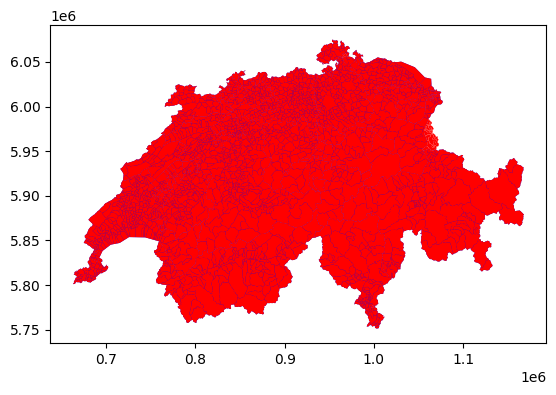

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Set up pyplot
fig, ax = plt.subplots()

# Draw cantons in blue
kantone = municipalities[municipalities['type'] == 'Kanton']
kantone.plot(ax=ax, color='blue')

# Overlay with towns in red
gemeinden = municipalities[municipalities['type'] == 'Gemeinde']
gemeinden.plot(ax=ax, color = 'red')

# Show!
plt.show()